# Lemmatization

# Dataset

In [1]:
import pandas as pd
import datetime
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Bidirectional, TimeDistributed, RepeatVector, Activation, Dot, Lambda
from keras import backend as K
import matplotlib.pyplot as plt
import seaborn as sns

# set all random seeds
np.random.seed(42)
tf.random.set_seed(42)

dataset_path = "./dev.csv"
df = pd.read_csv(dataset_path, sep="\t", header=None, names=["word", "tag", "lemm"])

dataset_path = "./test.csv"
df = pd.concat([df,pd.read_csv(dataset_path, sep="\t", header=None, names=["word", "tag", "lemm"])])

df["word"] = df["word"].astype(str) 
df["tag"] = df["tag"].astype(str)
df["lemm"] = df["lemm"].astype(str)

# remove duplicates in word columns
df = df.drop_duplicates(subset=["word"])

# remove head
df = df.iloc[1:]

# df = df[df["tag"] != "p_oth"]
# df = df[df["tag"] != "c_num"]

print("### DF shape:" ,df.shape)
print("\n### NaN values:")
print(df.isnull().sum())

# removing rows where tag is nan
df = df.dropna(subset=["tag"])
df = df[df["tag"] != "nan"]

print("\n### DF shape after removing rows where tag is nan:" ,df.shape)

# print number of unique values for each column
print("\n### Unique values:")
print(df.nunique())

# lower case all words
df["word"] = df["word"].str.lower()

# count number of row where word is equal to lemm
print("\n### Number of word that are equals to lemm:")
print(df[df["word"] == df["lemm"]].shape[0])

df.head()

### DF shape: (19789, 3)

### NaN values:
word    0
tag     0
lemm    0
dtype: int64

### DF shape after removing rows where tag is nan: (19726, 3)

### Unique values:
word    19726
tag        31
lemm    12643
dtype: int64

### Number of word that are equals to lemm:
9967


,word,tag,lemm
1,mi,pron_per,mi
2,riferisco,v_gvrb,riferire
3,al,prep_a,al
4,lavoro,nn,lavoro
5,dove,conj_s,dove


## Data Processing

In [2]:
# get all unique letter in words
characters = set()

for word in df["word"]:
    for letter in word:
        characters.add(letter)

for lemma in df["lemm"]:
    for letter in lemma:
        characters.add(letter)

# add padding and unknown to characters
characters.add(" ")

# the length of the vocab for one-hot encoded char
vocab_size = len(characters)

print("\n### Number of unique characters:", vocab_size)

# Input in a LSTM must have all the same length
# so we pad the words with spaces to have the same length
def pad_word(word, max_word_length):
    return word + " " * (max_word_length - len(word))

max_word_length = max(df["word"].str.len().max(), df["lemm"].str.len().max())
print("\n### Max word length:", max_word_length)
max_word_length +=1
max_word_length = int(max_word_length)

df["word"] = df["word"].apply(lambda x: pad_word(x, max_word_length))
df["lemm"] = df["lemm"].apply(lambda x: pad_word(x, max_word_length))

# order characters
characters = sorted(list(characters))


### Number of unique characters: 60

### Max word length: 25


### Word Encoding

In [3]:
# Each word is encoded as a list of one-hot encoded characters
char_enc = OneHotEncoder(sparse_output=False)
char_enc.fit([[char] for char in characters])

def encode_word(word):
    return char_enc.transform([[char] for char in word])

def decode_word(word):
    decoded_word = ""
    for c in word:
        decoded_word += char_enc.inverse_transform([c])[0]
    return decoded_word

# Applying the encoding to the words in the dataframe        
df["word_e"] = df["word"].apply(encode_word)
df["lemm_e"] = df["lemm"].apply(encode_word)

mask_value = char_enc.transform([[" "]])[0]

### Tag Encoding

In [4]:
tag_enc = OneHotEncoder(sparse_output=False)
tag_enc.fit(df[["tag"]])
df["tag_e"] = tag_enc.transform(df[["tag"]]).tolist()

# the length of the vocab for one-hot encoded pos
pos_size = len(tag_enc.categories_[0])
print("### Number of POS tags:", pos_size)

### Number of POS tags: 31


### Train Test Split

In [5]:
x_word  = np.array(df["word_e"].tolist())
x_tag   = np.array(df["tag_e"].tolist())
y = np.array(df["lemm_e"].tolist())
tag_list = df["tag"].tolist()

word_train, word_test, tag_train, tag_test, y_train, y_test, _, tag_list = train_test_split(x_word, x_tag, y, tag_list , test_size=0.1, random_state=42)
word_train, word_val, tag_train, tag_val, y_train, y_val = train_test_split(word_train, tag_train, y_train, test_size=0.02, random_state=42)

print("### Word train shape:", word_train.shape)
print("### Tag train shape:", tag_train.shape)
print("### Y train shape:", y_train.shape)

print("\n### Word val shape:", word_val.shape)
print("### Tag val shape:", tag_val.shape)
print("### Y val shape:", y_val.shape)

print("\n### Word test shape:", word_test.shape)
print("### Tag test shape:", tag_test.shape)
print("### Y test shape:", y_test.shape)

print("\n### Vocab size:", vocab_size)
print("### POS tag size:", pos_size)

### Word train shape: (17397, 26, 60)
### Tag train shape: (17397, 31)
### Y train shape: (17397, 26, 60)

### Word val shape: (356, 26, 60)
### Tag val shape: (356, 31)
### Y val shape: (356, 26, 60)

### Word test shape: (1973, 26, 60)
### Tag test shape: (1973, 31)
### Y test shape: (1973, 26, 60)

### Vocab size: 60
### POS tag size: 31


# Model

In [6]:
def get_model():
    # Inputs
    word_input = tf.keras.layers.Input(name="word_input", shape=(max_word_length, vocab_size))
    tag_input = tf.keras.layers.Input(name="tag_input", shape=(pos_size))

    word_input = tf.keras.layers.Masking(mask_value= mask_value)(word_input)

    # Bidirectional LSTM layer
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(word_input)
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(lstm)

    # Fully connected layer for tag_input
    tag_fc = tf.keras.layers.Dense(64, name="tag_dense", activation='swish')(tag_input)
    tag_fc = tf.keras.layers.Dropout(0.2)(tag_fc)
    tag_fc = tf.keras.layers.Dense(64, name="tag_dense2", activation='swish')(tag_fc)
    tag_fc = tf.keras.layers.RepeatVector(max_word_length)(tag_fc)

    # Concatenate the two inputs
    concat = tf.keras.layers.Concatenate()([lstm, tag_fc])

    # Fully connected layer
    fc = tf.keras.layers.Dense(64, name="lstm2dense", activation='swish')(concat)
    fc = tf.keras.layers.Dropout(0.2)(fc)
    fc = tf.keras.layers.Dense(64, name="dense2dense", activation='swish')(fc)
    
    # Output layer
    output = tf.keras.layers.Dense(vocab_size, name="output", activation='softmax')(fc)

    # Create model
    return tf.keras.models.Model(inputs=[word_input, tag_input], outputs=output)

# Create model
model = get_model()
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 tag_input (InputLayer)         [(None, 31)]         0           []                               
                                                                                                  
 tag_dense (Dense)              (None, 64)           2048        ['tag_input[0][0]']              
                                                                                                  
 input_1 (InputLayer)           [(None, 26, 60)]     0           []                               
                                                                                                  
 dropout (Dropout)              (None, 64)           0           ['tag_dense[1][0]']              
            

### Custom Accuracy

Each lemma is correct only if all the characters generated by the model are correct

In [7]:
def accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=-1)
    y_pred = tf.argmax(y_pred, axis=-1)
    correct_predictions = tf.reduce_all(tf.equal(y_true, y_pred), axis=-1)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

### Training

In [8]:
# Hyperparameters
epochs = 100
batch_size = 512

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H.%M.%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[accuracy])
history = model.fit([word_train, tag_train], y_train, epochs=epochs, batch_size=batch_size, validation_data=([word_val, tag_val], y_val), callbacks=[tensorboard_callback])

Epoch 1/100
34/34 [==============================] - 11s 190ms/step - loss: 1.7009 - accuracy: 0.0000e+00 - val_loss: 1.0293 - val_accuracy: 0.0000e+00
Epoch 2/100
34/34 [==============================] - 5s 134ms/step - loss: 0.9688 - accuracy: 0.0000e+00 - val_loss: 0.9095 - val_accuracy: 0.0000e+00
Epoch 3/100
34/34 [==============================] - 5s 133ms/step - loss: 0.9101 - accuracy: 1.1489e-04 - val_loss: 0.8761 - val_accuracy: 0.0000e+00
Epoch 4/100
34/34 [==============================] - 5s 133ms/step - loss: 0.8679 - accuracy: 5.7445e-05 - val_loss: 0.8181 - val_accuracy: 0.0000e+00
Epoch 5/100
34/34 [==============================] - 5s 133ms/step - loss: 0.7762 - accuracy: 2.2978e-04 - val_loss: 0.6517 - val_accuracy: 0.0000e+00
Epoch 6/100
34/34 [==============================] - 5s 132ms/step - loss: 0.5116 - accuracy: 0.0291 - val_loss: 0.2702 - val_accuracy: 0.2725
Epoch 7/100
34/34 [==============================] - 5s 132ms/step - loss: 0.2474 - accuracy: 0.2732 

# Evaluation

In [12]:
# evaluate the model
loss, acc = model.evaluate([word_test, tag_test], y_test, verbose=0)
print('### Test Accuracy: %f' % (acc*100))
print('### Test Loss: %f' % (loss))

### Test Accuracy: 91.150630
### Test Loss: 0.043829


## Lemmatization Accuracy

Lemmatisation accuracy is defined as the number of correct lemma assignment divided by the total number of tokens in the test set belonging to the considered lexical classes (ADJ_, ADV,NN, V_). 

(Evalita2011)

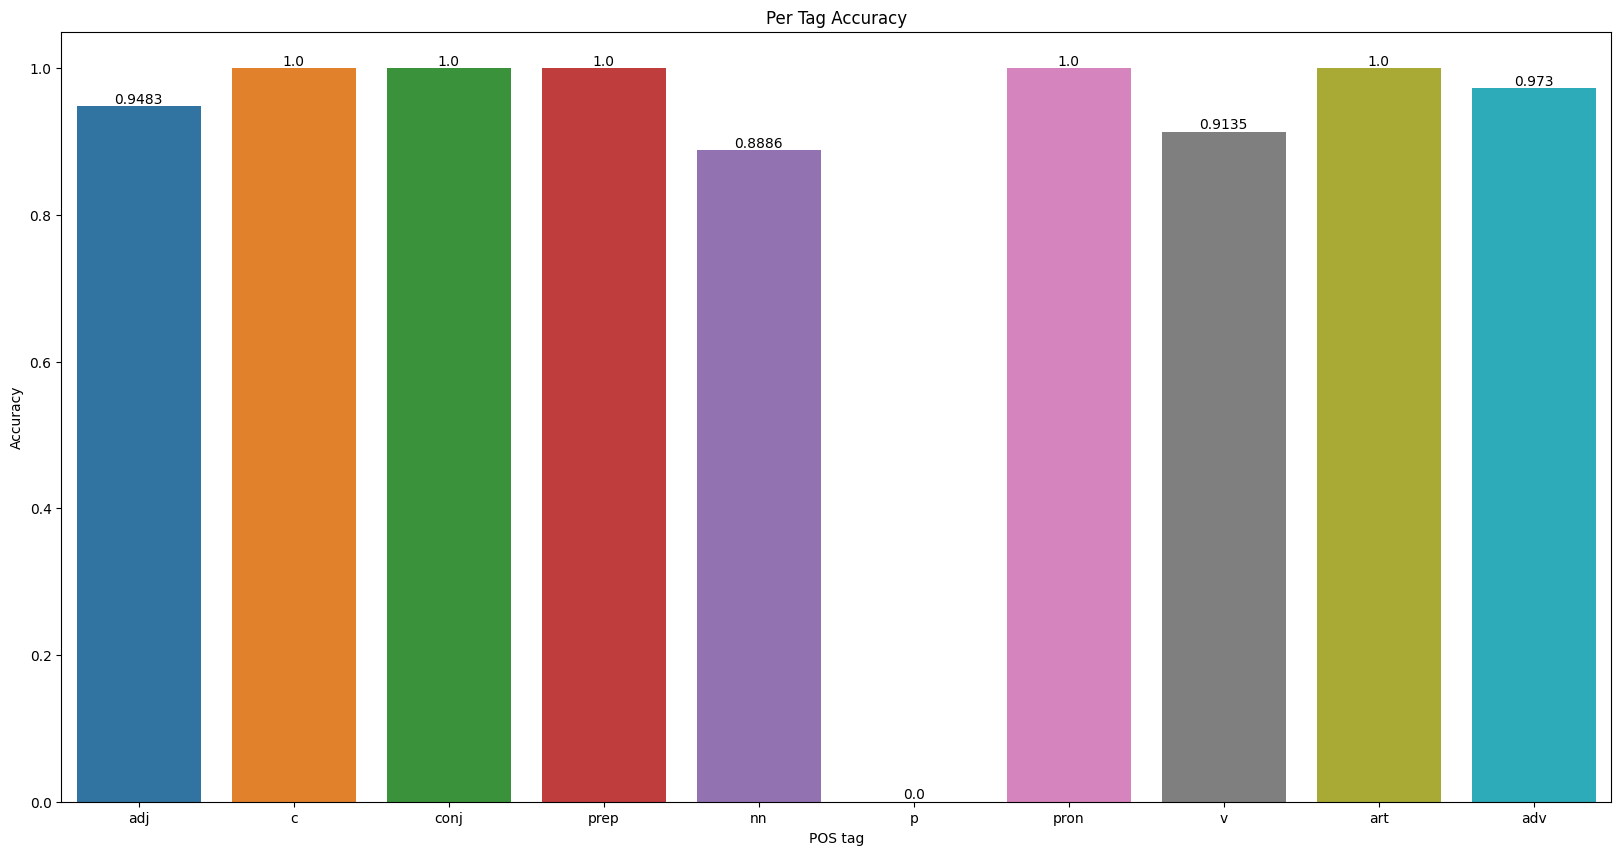

In [10]:
# Generate predictions for the test set
predictions = model.predict([word_test, tag_test], verbose=0)

# Convert predictions to lemmas
predicted_lemmas = [decode_word(pred) for pred in predictions]

total_counter = {}
correct_counter = {}
accuracies = {}

tags = set()

for t in tag_list:
    t = t.split("_")[0]
    total_counter[t] = 0
    correct_counter[t] = 0

# Compare predictions to actual lemmas
for i, lemma in enumerate(predicted_lemmas):
    tag = tag_list[i].split("_")[0]
    tags.add(tag)
    total_counter[tag] += 1
    if lemma == decode_word(y_test[i]):
        correct_counter[tag] += 1

    if tag == "nan":
        print("### Tag is nan for word", decode_word(word_test[i]))

# Calculate accuracy
for t in tags:
    accuracies[t] = round(correct_counter[t]/total_counter[t], 4)

# accuracies plot
plt.figure(figsize=(20, 10))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
for index, value in enumerate(list(accuracies.values())):
    plt.text(index, value, str(value), ha="center", va="bottom")
plt.title("Per Tag Accuracy")
plt.xlabel("POS tag")
plt.ylabel("Accuracy")
plt.show()

## Demo

In [11]:
# try the model with an example
n = np.random.randint(0, len(word_test))
word = word_test[n]
tag = tag_test[n]
y = y_test[n]

print("### Word:", decode_word(word))
print("### Tag:", tag_enc.inverse_transform([tag])[0])
print("### Lemma:", decode_word(y))

prediction = model.predict([np.array([word]), np.array([tag])], verbose=0)
print("### Lemma prediction:", decode_word(prediction[0]))

### Word: ['frattura                  ']
### Tag: ['nn']
### Lemma: ['frattura                  ']
### Lemma prediction: ['frattura                  ']
